In [24]:
"""
NYC Air Pollution Prediction Using EPA PM2.5 + GNN

Pipeline:
Load EPA Data → Filter NYC → Convert to GeoDataFrame →
Download NYC Roads → Spatial Join → Graph → GNN →
Prediction → Visualization

Author : Shreyansh Saurabh
"""

!pip install torch torchvision torchaudio
!pip install torch-geometric
!pip install geopandas shapely networkx pandas numpy matplotlib osmnx

In [2]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import torch
import torch.nn.functional as F
import osmnx as ox

from shapely.geometry import Point
from torch_geometric.utils import from_networkx
from torch_geometric.nn import GCNConv

In [6]:

from google.colab import drive
drive.mount('/content/drive')

df = pd.read_csv(
"/content/drive/MyDrive/nyc_air_quality/daily_88101_2023.csv"
)

print(df.head())
print(df.columns)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
   State Code  County Code  Site Num  Parameter Code  POC   Latitude  \
0           1            3        10           88101    3  30.497478   
1           1            3        10           88101    3  30.497478   
2           1            3        10           88101    3  30.497478   
3           1            3        10           88101    3  30.497478   
4           1            3        10           88101    3  30.497478   

   Longitude  Datum            Parameter Name Sample Duration  ... AQI  \
0 -87.880258  NAD83  PM2.5 - Local Conditions          1 HOUR  ... NaN   
1 -87.880258  NAD83  PM2.5 - Local Conditions          1 HOUR  ... NaN   
2 -87.880258  NAD83  PM2.5 - Local Conditions          1 HOUR  ... NaN   
3 -87.880258  NAD83  PM2.5 - Local Conditions          1 HOUR  ... NaN   
4 -87.880258  NAD83  PM2.5 - Local Conditions          1 HOUR  ... N

In [7]:
NY_STATE = 36

NYC_COUNTIES = [
    5,   # Bronx
    47,  # Brooklyn (Kings)
    61,  # Manhattan
    81,  # Queens
    85   # Staten Island
]

df_nyc = df[
    (df["State Code"] == NY_STATE) &
    (df["County Code"].isin(NYC_COUNTIES))
]

print(len(df_nyc))


4108


In [25]:
"""
Converts pollution measurements to spatial points
"""

df_nyc["geometry"] = df_nyc.apply(
    lambda row: Point(row["Longitude"], row["Latitude"]),
    axis=1
)

pollution = gpd.GeoDataFrame(df_nyc, geometry="geometry", crs="EPSG:4326")

/tmp/ipython-input-3969635162.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_nyc["geometry"] = df_nyc.apply(


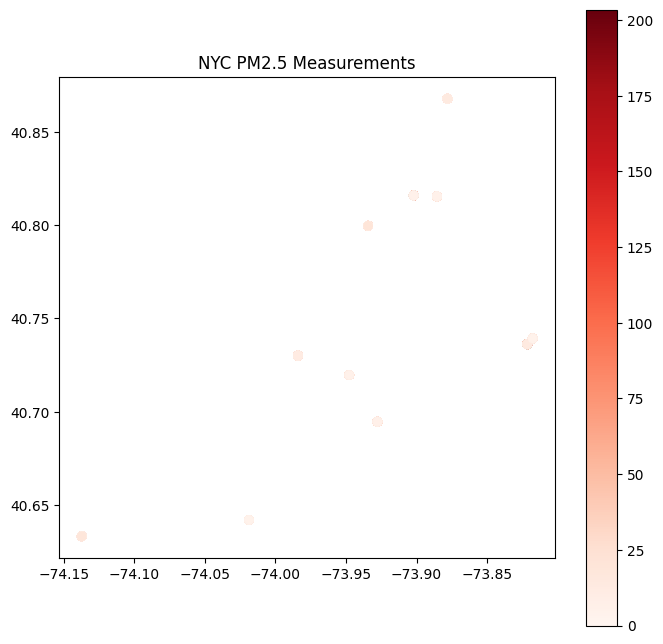

In [26]:
"""
Visualizes raw pollution measurement points
"""

pollution.plot(
    column="Arithmetic Mean",
    cmap="Reds",
    legend=True,
    figsize=(8,8)
)

plt.title("NYC PM2.5 Measurements")
plt.show()

In [27]:
"""
Downloads NYC road network from OpenStreetMap
"""

place = "New York City, New York, USA"
G_roads = ox.graph_from_place(place, network_type="drive")

nodes, edges = ox.graph_to_gdfs(G_roads)

In [28]:
"""
Attaches nearest pollution measurement to each road node
"""

pollution = pollution.to_crs(nodes.crs)

nodes_pollution = gpd.sjoin_nearest(
    nodes,
    pollution[["Arithmetic Mean","geometry"]],
    how="left"
)

nodes_pollution["Arithmetic Mean"] = nodes_pollution["Arithmetic Mean"].fillna(0)

/usr/local/lib/python3.12/dist-packages/geopandas/array.py:407: UserWarning: Geometry is in a geographic CRS. Results from 'sjoin_nearest' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  warnings.warn(


In [29]:
"""
Converts road graph to NetworkX graph
"""

G = nx.Graph()

for node in G_roads.nodes():
    G.add_node(node)

for u,v in G_roads.edges():
    G.add_edge(u,v)

In [30]:
"""
Attaches pollution values as node features
"""

node_pollution = nodes_pollution["Arithmetic Mean"].values

for i,node in enumerate(G.nodes()):
    if i < len(node_pollution):
        G.nodes[node]["pollution"] = node_pollution[i]
    else:
        G.nodes[node]["pollution"] = 0

In [31]:
"""
Prepares graph for GNN training
"""

features = []
labels = []

threshold = np.percentile(node_pollution, 70)

for node in G.nodes():
    val = G.nodes[node]["pollution"]
    features.append([val])
    labels.append(int(val > threshold))

data = from_networkx(G)

data.x = torch.tensor(features, dtype=torch.float)
data.y = torch.tensor(labels, dtype=torch.long)

In [32]:
"""
Defines Graph Neural Network model
"""

class GNN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = GCNConv(1,16)
        self.conv2 = GCNConv(16,2)

    def forward(self,data):
        x,edge=data.x,data.edge_index
        x=self.conv1(x,edge)
        x=F.relu(x)
        x=self.conv2(x,edge)
        return x

In [33]:
"""
Defines Graph Neural Network model
"""

class GNN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = GCNConv(1,16)
        self.conv2 = GCNConv(16,2)

    def forward(self,data):
        x,edge=data.x,data.edge_index
        x=self.conv1(x,edge)
        x=F.relu(x)
        x=self.conv2(x,edge)
        return x

In [34]:
"""
Trains pollution prediction model
"""

model = GNN()
opt = torch.optim.Adam(model.parameters(), lr=0.01)

for epoch in range(50):
    opt.zero_grad()
    out = model(data)
    loss = F.cross_entropy(out, data.y)
    loss.backward()
    opt.step()

    if epoch % 10 == 0:
        print(epoch, loss.item())

0 1.482748031616211
10 0.8126948475837708
20 0.6898918151855469
30 0.6512357592582703
40 0.6393658518791199


In [35]:
"""
Predicts pollution risk
"""

model.eval()
pred = model(data)
prob = torch.softmax(pred, dim=1)

fail_prob = prob[:,1].detach().numpy()

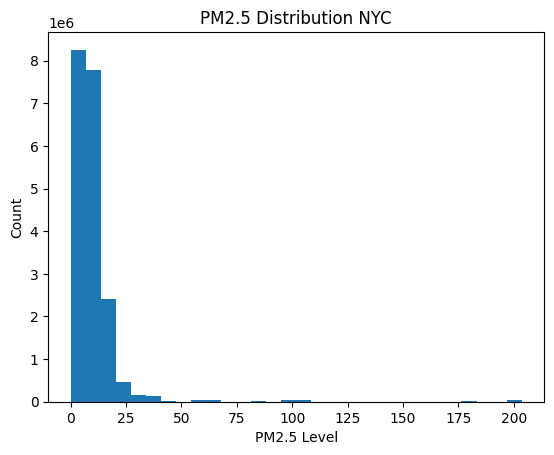

In [37]:
plt.hist(node_pollution, bins=30)
plt.title("PM2.5 Distribution NYC")
plt.xlabel("PM2.5 Level")
plt.ylabel("Count")
plt.show()

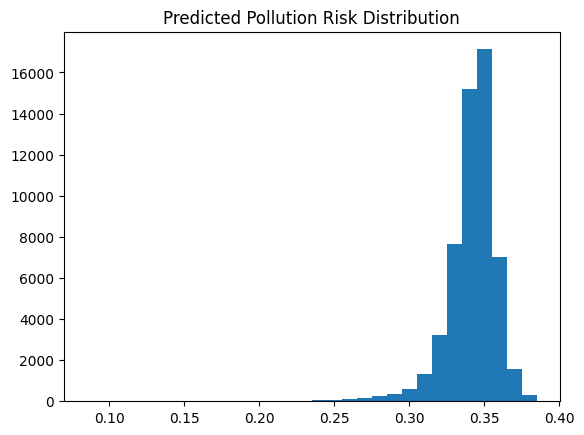

In [38]:
plt.hist(fail_prob, bins=30)
plt.title("Predicted Pollution Risk Distribution")
plt.show()